<a href="https://colab.research.google.com/github/egorssed/VAE_on_HST_galaxies/blob/main/Latent_space_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')
Folder='/content/drive/My Drive/AstroLensing/'

Mounted at /content/drive


In [2]:
y=pd.read_csv(Folder+"DataSet/New_images/Dataset_labels_scaled_max.csv",index_col=0)
X=np.load(Folder+"DataSet/Unnormalized_images//Latent_space.npy")

In [3]:
y.head()

,IDENT,Manual_noise_sigma,Original_size,fit_dvc_btt,fit_mad_b,fit_mad_s,flux,flux_radius,mag_auto,maxI_4_CV,use_bulgefit,viable_sersic,zphot,Sersic_I,Sersic_HLR,Sersic_n,Sersic_q,Sersic_boxiness,Sersic_phi,Bulge_I,Bulge_HLR,Bulge_n,Bulge_q,Bulge_boxiness,Bulge_phi,Disk_I,Disk_HLR,Disk_n,Disk_q,Disk_boxiness,Disk_phi,HLRcirc_Sersic,HLRcirc_Bulge,HLRcirc_Disk,fit_status_0,fit_status_1,fit_status_2,fit_status_3,fit_status_4,SNR_Manual,NonUniformity,maxI
0,141190,0.008710,242,0.072256,0.002850,0.002923,99.841270,7.310604,21.040642,0.441848,0,1,0.1950,0.013363,10.856601,1.145393,0.320146,0.0,1.649815,0.012038,10.888095,1.0,0.351040,0.0,1.632422,0.004279,10.033260,4.0,0.050000,0.0,1.698688,6.142818,0.00000,0.000000,1.0,1.0,1.0,1.0,1.0,50.727741,42.000836,1.023790
1,143346,0.007900,144,0.006207,0.002618,0.002648,47.668005,8.154056,21.782894,0.184937,0,1,0.7552,0.014111,9.301698,0.809802,0.694176,0.0,-1.910366,0.011899,9.928521,1.0,0.690269,0.0,1.224553,0.258925,0.132454,4.0,0.614526,0.0,2.009977,7.749919,0.00000,0.000000,1.0,1.0,1.0,1.0,1.0,23.411050,29.116470,0.345019
2,93315,0.005307,92,0.008065,0.004632,0.004639,21.396968,4.657753,22.861856,0.149750,0,1,0.9616,0.051727,4.763626,0.840383,0.637208,0.0,2.113670,0.047064,4.870544,1.0,0.637739,0.0,-1.019702,0.528859,0.347635,4.0,0.050000,0.0,-3.063154,3.802580,0.00000,0.000000,1.0,1.0,1.0,1.0,1.0,28.217329,61.255597,0.273879
3,129658,0.005357,112,0.191620,0.002874,0.002959,24.274229,10.014692,22.504494,0.108650,1,1,1.0986,0.007964,12.929523,1.364607,0.411593,0.0,-0.224501,0.008060,13.861269,1.0,0.327986,0.0,-0.251854,0.000835,13.861269,4.0,0.414341,0.0,0.989760,8.295007,8.92241,7.938353,1.0,1.0,1.0,1.0,1.0,20.282247,26.478137,0.150976
4,9205,0.007133,124,0.050223,0.002835,0.002975,37.317560,7.358890,22.131260,0.153872,0,1,0.4449,0.019680,9.018477,0.832925,0.499250,0.0,0.280726,0.015331,9.624029,1.0,0.527362,0.0,0.260606,0.004720,9.624029,4.0,0.050000,0.0,0.376971,6.372244,0.00000,0.000000,1.0,1.0,1.0,1.0,1.0,21.572091,27.345317,0.250405


In [4]:
y_Sersic=y[['Sersic_HLR', 'Sersic_n', 'Sersic_q','Sersic_phi']]

In [5]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y_Sersic, test_size=0.2)

In [6]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import r2_score

# Predict whole set of Sersic parameters

In [ ]:
RandF= RandomForestRegressor(random_state=42)
RandF.fit(x_train, y_train)
print('Random Forest R2 score {:.2f}'.format(r2_score(y_test,RandF.predict(x_test))))

Random Forest R2 score 0.54


In [ ]:
grB=MultiOutputRegressor(
    GradientBoostingRegressor(random_state=42))
grB.fit(x_train, y_train)
print('Grad Boost R2 score {:.2f}'.format(r2_score(y_test,grB.predict(x_test))))

Grad Boost R2 score 0.59


# Predict Features one by one

In [7]:
def test_model(model,x,y):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
    for i,column in enumerate(y.columns):
        regr=model(random_state=42)
        regr.fit(x_train, y_train[column])
        #print(column,'R2 {:.2f}'.format(r2_score(y_test[column],regr.predict(x_test))))
        print(column,' MRAE {:.2f}'.format(np.abs((y_test[column]-regr.predict(x_test))/y_test[column]).mean()))
    return 

In [23]:
print('Random forest predictions')
test_model(RandomForestRegressor,X,y_Sersic)

Random forest predictions
Sersic_HLR  MRAE 0.12
Sersic_n  MRAE 0.26
Sersic_q  MRAE 0.15
Sersic_phi  MRAE 0.91


In [24]:
print('Grad Boost predictions')
test_model(GradientBoostingRegressor,X,y_Sersic)

Grad Boost predictions
Sersic_HLR  MRAE 0.13
Sersic_n  MRAE 0.27
Sersic_q  MRAE 0.17
Sersic_phi  MRAE 1.15


# PCA processing

In [8]:
from sklearn.decomposition import PCA

In [9]:
pca = PCA(n_components=2)
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [10]:
def test_model_PCA(model,x,y,PCA_components):
    pca = PCA(n_components=PCA_components)
    x_train, x_test, y_train, y_test = train_test_split(pca.fit_transform(x), y, test_size=0.2)
    models=np.zeros(4)
    for i,column in enumerate(y.columns):
        regr=model(random_state=42)
        regr.fit(x_train, y_train[column])
        models[i]=np.abs((y_test[column]-regr.predict(x_test))/y_test[column]).mean()
    return models

In [16]:
scores_RandF=np.zeros((7,4))
PCA_components=[6,8,10,13,16,32,64]
for i,n in tqdm(enumerate(PCA_components)):
    scores_RandF[i]=test_model_PCA(RandomForestRegressor,X,y_Sersic,n)

7it [18:36, 159.43s/it]


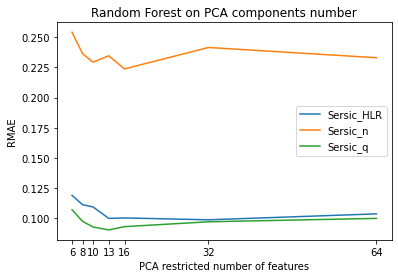

In [17]:
for i,feature in enumerate(['Sersic_HLR', 'Sersic_n', 'Sersic_q']):
  plt.plot(PCA_components,scores_RandF[:,i],label=feature)
plt.title('Random Forest on PCA components number')
plt.xticks(PCA_components)
plt.xlabel('PCA restricted number of features')
plt.ylabel('RMAE')
plt.legend()
plt.show()

In [11]:
scores_GrB=np.zeros((7,4))
PCA_components=[6,8,10,13,16,32,64]
for i,n in tqdm(enumerate(PCA_components)):
    scores_GrB[i]=test_model_PCA(GradientBoostingRegressor,X,y_Sersic,n)

7it [07:46, 66.58s/it]


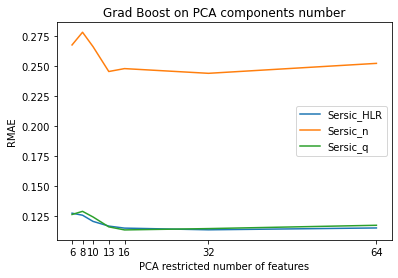

In [14]:
for i,feature in enumerate(['Sersic_HLR', 'Sersic_n', 'Sersic_q']):
  plt.plot(PCA_components,scores_GrB[:,i],label=feature)
plt.title('Grad Boost on PCA components number')
plt.xticks(PCA_components)
plt.xlabel('PCA restricted number of features')
plt.ylabel('RMAE')
plt.legend()
plt.show()